# Medical Report Generation Case Study

### [1.0] Business Problem
- Medical images are widely used in clinical decision making. For example, chest x-ray images are used for diagnosing pneunomia and pleutral effusion.
- The interpretaion of medical images requires extensive expertise and are prone to human errors. Considering the demands of accurately interpreting medical images in large amounts within short times, an automatic medical report generation model can be very useful.

### [1.1] Problem Statement
For a given chest X-ray image we need to generate medical conclusive report for helping the doctors in understanding and proceeding with further treatments.

### [1.2] References
- http://academictorrents.com/details/66450ba52ba3f83fbf82ef9c91f2bde0e845aba9
- http://academictorrents.com/details/5a3a439df24931f410fac269b87b050203d9467d  
- https://medium.com/@Petuum/on-the-automatic-generation-of-medical-imaging-reports-7d0a7748fe3d
- https://mc.ai/medical-report-generation-using-deep-learning/
- https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
- https://guillaumegenthial.github.io/sequence-to-sequence.html
- https://guillaumegenthial.github.io/image-to-latex.html

### [2.0] Data Overview
- The data is in two different folders, one contains only images and another contain reports.
- Reports data is stored in XML file and total size of data stored in XML format is 30.1 MB
- Total number of reports are 3955
- Total size of images data is 1.28 GB
- Total number of images are 7470

### [2.1] Data Field Explanation
- COMPARISON: Information about the type of chest view
- INDICATION: These field basically explains the type of disease in the patient
- FINDINGS: These field explains in detail about the indication and the chest x-ray image
- IMPRESSION: These concludes are report stating whether report is normal or not
- image_id: ID associated with each x-ray image

### Performance Metric:
- BLEU(Bilingual Evaluation Understudy)
- BLEU is an evaluation metric initially  proposed for machine translation  and defined as a geometric mean of  n-gram precision scores multiplied by a brevity penalty for short  sentences. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
#tf.enable_eager_execution()
tf.executing_eagerly() 

True

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import re
import xml.etree.ElementTree as ET
import random
import os, argparse
import cv2, spacy, numpy as np
from os import path 
from tensorflow.keras.models import load_model
from tensorflow.keras import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD
from sklearn.externals import joblib
from nltk.translate.bleu_score import corpus_bleu
#from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import csv
import numpy as np
import pandas as pd
import os
import xmltodict
from xml.dom import minidom
#K.set_image_data_format('channels_first')

### [2.2] Example Data Point

In [3]:
# Reference : https://www.guru99.com/manipulating-xml-with-python.html
# YouTube : https://www.youtube.com/watch?v=DejHQYAGb7Q
# https://docs.python.org/3.4/library/xml.etree.elementtree.html
import xml.etree.ElementTree as ET
col_list = list()
file = 'G:/Self Case Study II/NLMCXR_reports/ecgen-radiology/10.xml'
tree = ET.parse(file)
root = tree.getroot()
for child in root:
    if child.tag == 'MedlineCitation':
        for attr in child:
            if attr.tag == 'Article':
                for i in attr:
                    if i.tag == 'Abstract':
                        for name in i:
                            if name.get('Label') == 'COMPARISON':
                                comparison = name.text
                            elif name.get('Label') == 'INDICATION':
                                indication = name.text
                            elif name.get('Label') == 'FINDINGS':
                                findings = name.text
                            elif name.get('Label') == 'IMPRESSION':
                                impression = name.text
        for p_image in root.findall('parentImage'):
            idd = p_image.get('id')
            print('\nComparison: ',comparison)
            print('\nIndication: ',indication)
            print('\nFindings: ',findings)
            print('\nImpression: ',impression)
            print('\nID: ',idd)
            break


Comparison:  Chest radiographs XXXX.

Indication:  XXXX-year-old male, chest pain.

Findings:  The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Stable calcified granuloma within the right upper lung. No acute bone abnormality..

Impression:  No acute cardiopulmonary process.

ID:  CXR10_IM-0002-1001


### [3.0] EDA

### [3.1] Total number of images

In [4]:
directory = 'G:/Self Case Study II/NLMCXR_png'
total_images = os.listdir(directory)
print('Total number of images: ',len(total_images))

Total number of images:  7470


In [5]:
count=0
print("Name of the X-ray file:")
for name in os.listdir(directory): 
    if count==3:
        break
    image_id = name.split('.')[0] 
    print('\n',image_id)
    count += 1

Name of the X-ray file:

 CXR1000_IM-0003-1001

 CXR1000_IM-0003-2001

 CXR1000_IM-0003-3001


In [5]:
##Getting size of images
directory = 'G:/Self Case Study II/NLMCXR_png'
list_of_heights = []
list_of_widths = []
#for i in os.listdir(directory):
for image in os.listdir(directory):
    img = cv2.imread(directory + '/'+ image)
        # get dimensions of image
    shape = img.shape
    list_of_heights.append(shape[0])
    list_of_widths.append(shape[1])

Text(0.5, 1.0, 'heights')

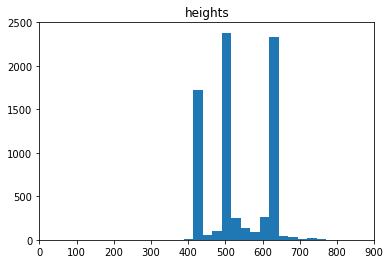

In [6]:
##plotting 
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list_of_heights,bins=20)
plt.xlim(0,900)
plt.title('heights')

In [7]:
np.median(list_of_heights)

512.0

In [8]:
np.mean(list_of_heights)

532.7789825970549

In [9]:
np.median(list_of_widths)

512.0

In [10]:
np.mean(list_of_widths)

512.0

### [3.2] Total number of reports

In [5]:
directory = 'G:/Self Case Study II/NLMCXR_reports/ecgen-radiology'
total_reports = os.listdir(directory)
print('Total number of reports: ',len(total_reports))

Total number of reports:  3955


In [6]:
count=0
print("Name of the XML file:")
for name in os.listdir(directory): 
    if count==10:
        break
    report_id = name.split('.')[0] 
    print(report_id)
    count += 1

Name of the XML file:
1
10
100
1000
1001
1002
1003
1004
1005
1006


- If we notice the report file names are following table of ten and after 1000, they are following regular number

In [7]:
import cv2
import numpy as np

# Load image, create mask, grayscale, Gaussian blur, Otsu's threshold
image = cv2.imread('G:/Self Case Study II/NLMCXR_png/CXR1000_IM-0003-1001.png')
cv2.imshow

<function imshow>

#### In the step below we are performing data augmentation on our image data

In [3]:
datagen = ImageDataGenerator(
        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True )

#### Function for extracting features from image data

In [4]:
from pickle import dump
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

model = VGG16()
# re-structure the model
model.layers.pop()
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
features = dict()
filename = 'G:/Self Case Study II/NLMCXR_png/CXR1000_IM-0003-1001.png'

In [5]:
image = load_img(filename, target_size = (224,224))

image = img_to_array(image)

image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))

image = preprocess_input(image)

feature = model.predict(image,verbose = 0)

name = 'CXR1000_IM-0003-1001'

image_id = name.split()[0]

features[image_id] = feature


In [11]:
#features[image_id][0]
arr = features[image_id]
print(type(arr))
arr = arr.ravel()

<class 'numpy.ndarray'>


In [12]:
filename = 'image.tfrecord'
with tf.io.TFRecordWriter(filename) as writer:
    record_bytes = tf.train.Example(features=tf.train.Features(feature={
        "x": tf.train.Feature(float_list=tf.train.FloatList(value=arr))
    })).SerializeToString()
    writer.write(record_bytes)

In [13]:
def decode_fn(record_bytes):
    return tf.io.parse_single_example(
      # Data
      record_bytes,

      # Schema
      {"x": tf.io.FixedLenFeature([4096], dtype=tf.float32)}
  )
dataset = tf.data.TFRecordDataset([filename]).map(decode_fn)

In [7]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [30]:
arr = features[image_id]
print(type(arr))
arr = arr.ravel()

<class 'numpy.ndarray'>


In [4]:
filename_ = 'image.tfrecord'

def decode_fn(record_bytes):
    return tf.io.parse_single_example(
      # Data
      record_bytes,

      # Schema
      {"x": tf.io.FixedLenFeature([4096], dtype=tf.float32)})
        


def extract_features(directory):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # summarize
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in tqdm(os.listdir(directory)):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        #print('>%s' % name)
        it = datagen.flow(image, batch_size = 1)
        
        for i in range(1,3):
            
            batch = it.next()
            image = preprocess_input(batch)
            feature = model.predict(image, verbose = 0)
            id_ = image_id + str(i)
            features[id_] = feature
        arr = features[id_]
        arr = arr.ravel()
    
        with tf.io.TFRecordWriter(filename_) as writer:
            record_bytes = tf.train.Example(features=tf.train.Features(feature={
            "x": tf.train.Feature(float_list=tf.train.FloatList(value=arr))
            })).SerializeToString()
            writer.write(record_bytes)
    
    dataset = tf.data.TFRecordDataset([filename_]).map(decode_fn)
    
    return dataset
    

In [5]:
from pickle import dump
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

path = 'G:/Self Case Study II/NLMCXR_png'
features = extract_features(path)

  0%|                                                                                         | 0/7470 [00:00<?, ?it/s]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 224, 224)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 224, 224)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 112, 112)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 112, 112)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 112, 112)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 56, 56)       0   

100%|████████████████████████████████████████████████████████████████████████████| 7470/7470 [1:25:24<00:00,  1.46it/s]


In [12]:
print('Extracted Features: %d' ,(features))

Extracted Features: %d <MapDataset shapes: {x: (4096,)}, types: {x: tf.float32}>


In [8]:
for i in features.take(1000):
    print(i)

{'x': <tf.Tensor: id=68111, shape=(4096,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , ..., 0.9479164 , 0.        ,
       0.52387136], dtype=float32)>}


In [11]:
print('Vector size of extracted feature: ', len(features['CXR1000_IM-0003-3001'][0]))

Vector size of extracted feature:  4096


In [12]:
dump(features, open('features.pkl', 'wb'))

In [4]:
filename = 'image.tfrecord'
filenames = [filename]
dataset = tf.data.TFRecordDataset(filenames)
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [6]:
for i in dataset.take(10):
    print(repr(dataset))

<TFRecordDatasetV2 shapes: (), types: tf.string>


## Loading Image features from saved pickle file

In [4]:
from tensorflow.keras.models import load_model 
from pickle import load
filename = 'features.pkl'
features = load(open(filename, 'rb'))


In [5]:
print('After loading saved features pickle file:')
print('\nTotal number of images: ',len(features))
print('Vector size of extracted feature: ', len(features['CXR1000_IM-0003-3001'][0]))

After loading saved features pickle file:

Total number of images:  22410
Vector size of extracted feature:  4096


### Loading Text data

In [6]:
import os
from tqdm import tqdm
from os import path 
import xml.etree.ElementTree as ET
id_imp = dict()
id_find = dict()
directory = 'G:/Self Case Study II/NLMCXR_reports/ecgen-radiology'

for fname in tqdm(os.listdir(directory)):
    if fname.endswith('.xml'):
        f = path.join(directory,fname)
        tree = ET.parse(f)
        root = tree.getroot()
        for child in root:
            if child.tag == 'MedlineCitation':
                for attr in child:
                    if attr.tag == 'Article':
                        for i in attr:
                            if i.tag == 'Abstract':
                                for name in i:
                                    if name.get('Label') =='FINDINGS':
                                        finding = name.text
                                    elif name.get('Label') == 'IMPRESSION':
                                        impression = name.text
        
        for p_image in root.findall('parentImage'):
            idd = p_image.get('id')
            id_imp[idd] = impression
            id_find[idd] = finding
            for i in range(1,3):
                id_ = idd + str(i)
                id_imp[id_] = impression
                id_find[id_] = finding

100%|█████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:30<00:00, 128.21it/s]


### Data Cleaning

In [7]:
cnt = 0
# In this step we are basically counting the total number of None values
for k,v in id_imp.items():
    if id_imp[k] is None:
        cnt += 1
print('Total count of None values are: ',cnt)

Total count of None values are:  156


In [8]:
cnt = 0

for k,v in id_find.items():
    if id_find[k] is None:
        cnt += 1
print('Total count of none values in finding: ',cnt)

Total count of none values in finding:  2991


In [9]:
cnt = 0

for k,v in id_imp.items():
    if (id_find[k]) and (id_imp[k]) is None:
        cnt += 1
print('Total count of None values in findings and impression are: ',cnt)

Total count of None values in findings and impression are:  36


In [10]:
cnt = 0

for k,v in id_find.items():
    if (id_find[k]) or (id_imp[k]) is None:
        cnt += 1
print('Total count of None values in findings or impression are: ',cnt)

Total count of None values in findings or impression are:  19539


- In the code snippet above we are trying to count the total number None values either in findings or impressions of text data
- Total number of None values in findings or impressions are 19539
- We delete the findings and impressions with None values in the next step

### Delete None values

In [11]:
id_imp_none_rem = dict()
cnt = 0
cnt1 = 156

for k,v in id_imp.items():
    if v is not None:
        cnt += 1
        id_imp_none_rem[k] = v
print('Total number of none values',str(len(id_imp))+ ' - '+ str(cnt1) +' = '+str(cnt) )

Total number of none values 22410 - 156 = 22254


- Now we will remove the None values from findings and impressions
- We are storing our impressions without None values in a dictionary variable called id_imp_none_rem

In [12]:
cnt = 0

finding_none_values = dict()

for k,v in id_find.items():
    if (id_imp[k] is None) or (id_find[k] is None):
        cnt += 1
        continue
    else:
        finding_none_values[k] = v
print('Total none values in findings and impressions are: ',cnt)
print('Number of final findings without None values are: ',str(len(finding_none_values)))

Total none values in findings and impressions are:  3027
Number of final findings without None values are:  19383


- We removed None values from impressions and now we do the same for findings
- we store our final findings without None values in a dictionary variable called finding_none_values.

## [4.0] Text Preprocessing

In [13]:
import re
def clean_desc(desc,add_token):
    '''Function for cleaning the description text in findings and impressions'''
    descriptions = dict()
    for k,v in desc.items():
        sent = v.replace('x-XXXX',' ')
        sent = sent.lower()
        sent = sent.replace('xxxx',' ')
        sent = sent.replace('x-xxxx',' ')
        sent = re.sub('[^A-Za-z]+',' ',sent)
        if add_token == 'yes':
            sent = 'startseq ' + sent + ' endseq'
        descriptions[k] = sent.strip()
    return descriptions

clean_imp = clean_desc(id_imp_none_rem,'yes')
clean_finding = clean_desc(finding_none_values,'yes')

In [14]:
clean_imp['CXR1_1_IM-0001-3001']

'startseq normal chest  endseq'

In [15]:
clean_finding['CXR1_1_IM-0001-3001']

'startseq the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no of a pleural effusion there is no evidence of pneumothorax  endseq'

- If we notice the above two results we can say our function for cleaning the description text works absolutely fine
- We are using simple regex for cleaning our data and majorly we are cleaning (XXXX) values which was found extensively in our text data.

## [1.0] Building model using both findings and impressions

In [16]:
lst = list(clean_finding.keys())
random.shuffle(lst)
train_id,cv_id,test_id = lst[0:18883],lst[18883:19133],lst[19133:]
train_id = dict.fromkeys(train_id,1)
cv_id = dict.fromkeys(cv_id,1)
test_id = dict.fromkeys(test_id,1)
print('train data ', len(train_id))
print('cv data ',len(cv_id))
print('test data ',len(test_id))

train data  18883
cv data  250
test data  250


In [17]:
#Reference: https://stackabuse.com/text-generation-with-python-and-tensorflow-keras/
def create_seq(tokenizer, max_length, descriptions, image_feat,finding_features, vocab_size):
    '''This function creates a sequence of our text data to be fed as an input to our decoder model'''
    lst1 = list()
    lst2 = list()
    lst3 = list()
    y = list()
    
    #walk through each image identifier
    for k,v in descriptions.items():
        #encode the sequence
        seq = tokenizer.texts_to_sequences([v])[0]
        #split it into multiple X,y pairs
        for i in range(1, len(seq)):
            #split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            #pad input sequence
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            #encode output sequence
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            
            lst1.append(image_feat[k][0])
            lst2.append(finding_features[k])
            lst3.append(in_seq)
            
            y.append(out_seq)
            
    return np.array(lst1) ,np.array(lst2),np.array(lst3), np.array(y)

def load_respective_set(dict_,dataset):
    '''This function load a description of a given datapoint'''
    descriptions = dict()
    for k,v in dataset.items():
        descriptions[k] = dict_[k]
    return descriptions

def load_image_feat(dict_, dataset):
    '''This function returns image features extracted from our VGG16 model'''
    features = {k: dict_[k] for k in dataset}
    return features

def finding_sequences(tokenizer,max_len,id_findings):
    '''This function creates a sequence of findings'''
    findings = dict()
    for k,v in id_findings.items():
        seq = tokenizer.texts_to_sequences([v])[0]
        seq = pad_sequences([seq], maxlen = max_len)[0]
        findings[k] = seq
    return findings

def create_tokenizer(descriptions):
    '''This function would simpy fit a tokenizer for any given descriptions'''
    lines = list(descriptions.values())
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

## [1.1] Prepare Train Data

In [18]:
train_id_findings = load_respective_set(clean_finding, train_id) 
print('Total train Descriptions           : ',len(train_id_findings))

train_image_features = load_image_feat(features,train_id) 
print('\nTotal train images                   : ' ,len(train_image_features))

# prepare tokenizer 
find_tokenizer = create_tokenizer(train_id_findings) 


find_vocab_size = len(find_tokenizer.word_index) + 1 
print('\nVocabulary Size                       : ', find_vocab_size)

# pad to fixed length 
max_length = max(len(s.split()) for s in list(train_id_findings.values()))
print('\nDescription maximum Length  : ',max_length)

train_find_seq = finding_sequences(find_tokenizer,max_length, train_id_findings)

Total train Descriptions           :  18883

Total train images                   :  18883

Vocabulary Size                       :  1565

Description maximum Length  :  168


In [19]:
#Reference: https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db
embeddings_dict = {}
with open("glove.6B.300d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [20]:
find_embedding_matrix = np.zeros((find_vocab_size, 300))
for word, i in find_tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        find_embedding_matrix[i] = embedding_vector

In [21]:
train_id_impressions=load_respective_set(clean_imp, train_id) 
print('Total train Descriptions           : ',len(train_id_impressions))


# prepare tokenizer 
imp_tokenizer = create_tokenizer(train_id_impressions) 

imp_vocab_size = len(imp_tokenizer.word_index) + 1 
print('\nVocabulary Size                       : ', imp_vocab_size)

# pad to fixed length 
imp_max_length = max(len(s.split()) for s in list(train_id_impressions.values()))
print('\nDescription maximum Length  : ',imp_max_length)

Total train Descriptions           :  18883

Vocabulary Size                       :  1208

Description maximum Length  :  114


In [22]:
imp_embedding_matrix = np.zeros((imp_vocab_size, 300))
for word, i in imp_tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        imp_embedding_matrix[i] = embedding_vector

In [23]:
X1train,X2train,X3train,ytrain = create_seq(imp_tokenizer,imp_max_length,train_id_impressions,
                                           train_image_features,train_find_seq,find_vocab_size)

## [1.2] Prepare CV Data

In [24]:
cv_id_impressions=load_respective_set(clean_imp, cv_id) 
print('\nTotal cv Descriptions : ',len(cv_id_impressions))

cv_image_features = load_image_feat(features,cv_id) 
print('\nTotal cv images       : ' ,len(cv_image_features))

print('----------------------------------------------')

cv_findings = load_respective_set(clean_finding,cv_id)
print('\nTotal cv findings     : ',len(cv_findings))

cv_find_seq = finding_sequences(find_tokenizer,max_length,cv_findings)

# prepare sequences 
X1cv, X2cv,X3cv, ycv = create_seq(imp_tokenizer,imp_max_length,cv_id_impressions,
                                           cv_image_features,cv_find_seq,find_vocab_size)


Total cv Descriptions :  250

Total cv images       :  250
----------------------------------------------

Total cv findings     :  250


## [1.3] Training model using findings and impressions

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Concatenate
from tensorflow import concat
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
def define_model(find_vocab_size, find_max_length,find_embedding_matrix,imp_vocab_size,imp_max_length,imp_embedding_matrix):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.3)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # sequence model for findings
    inputs2 = Input(shape=(find_max_length,))
    se1 = Embedding(find_vocab_size,300,weights = [find_embedding_matrix], trainable = False, mask_zero=True)(inputs2)
    se2 = Flatten()(se1)
    #se4 = LSTM(256)(se1)
    
    concat_ = concat([fe2,se2] ,axis = 1)
    
    #sequence model for impressions
    inputs3 = Input(shape=(imp_max_length,))
    imp_1 = Embedding(imp_vocab_size, 300,weights = [imp_embedding_matrix], trainable = False, mask_zero=True)(inputs3)
    imp_2 = Dropout(0.3)(imp_1)
    imp_3 = LSTM(256)(imp_2)
    
    # decoder model
    decoder1 = concat([concat_,imp_3], axis = 1)
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(find_vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2,inputs3], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model_findings_impressions.png', show_shapes=True)
    return model

In [27]:
model = define_model(find_vocab_size, max_length,find_embedding_matrix,imp_vocab_size,imp_max_length,imp_embedding_matrix)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 168)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 114)]        0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [28]:
print(X1train.shape)
print(X2train.shape)
print(X3train.shape)

(160553, 4096)
(160553, 168)
(160553, 114)


In [29]:
xtrain = [X1train,X2train,X3train]
xcv = [X1cv,X2cv,X3cv]

# define checkpoint callback 
filepath = 'model/model_find_imp2-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min') 

# fit model 
h=model.fit(xtrain, ytrain,batch_size=128, epochs=20, verbose=2,callbacks = [checkpoint], validation_data=(xcv, ycv))

Train on 160553 samples, validate on 2268 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 1.59588, saving model to model/model_find_imp2-ep001-loss2.390-val_loss1.596.h5
160553/160553 - 195s - loss: 2.3899 - val_loss: 1.5959
Epoch 2/20

Epoch 00002: val_loss improved from 1.59588 to 0.91216, saving model to model/model_find_imp2-ep002-loss1.066-val_loss0.912.h5
160553/160553 - 187s - loss: 1.0665 - val_loss: 0.9122
Epoch 3/20

Epoch 00003: val_loss improved from 0.91216 to 0.64340, saving model to model/model_find_imp2-ep003-loss0.664-val_loss0.643.h5
160553/160553 - 186s - loss: 0.6642 - val_loss: 0.6434
Epoch 4/20

Epoch 00004: val_loss improved from 0.64340 to 0.43049, saving model to model/model_find_imp2-ep004-loss0.474-val_loss0.430.h5
160553/160553 - 188s - loss: 0.4742 - val_loss: 0.4305
Epoch 5/20

Epoch 00005: val_loss improved from 0.43049 to 0.34899, saving model to model/model_find_imp2-ep005-loss0.371-val_loss0.349.h5
160553/160553 - 188s - loss: 0.3706 - v

## [1.4] Prepare Test Data

In [26]:
test_id_impressions=load_respective_set(clean_imp, test_id) 
print('\nTotal test Descriptions : ',len(test_id_impressions))

test_image_features = load_image_feat(features,test_id) 
print('\nTotal test images       : ' ,len(test_image_features))

print('----------------------------------------------')

test_findings = load_respective_set(clean_finding,test_id)
print('\nTotal test findings     : ',len(test_findings))

test_find_seq = finding_sequences(find_tokenizer,max_length,test_findings)

# prepare sequences 
#X1test, X2test,X3test, ytest = create_seq(imp_tokenizer,imp_max_length,test_id_impressions,
           #                                test_image_features,test_find_seq,find_vocab_size)


Total test Descriptions :  250

Total test images       :  250
----------------------------------------------

Total test findings     :  250


In [27]:
def word_for_id(integer, tokenizer): 
    for word, index in tokenizer.word_index.items(): 
        if index == integer: 
            return word 
    return None


# generate a description for an image 
def generate_desc(model, tokenizer, photo, max_length,finding): 
    # seed the generation process 
    in_text = 'startseq' 
    #photo = photo.reshape((1,photo.shape[0]))
    finding = finding.reshape((1,finding.shape[0]))
    # iterate over the whole length of the sequence 
    for i in range(max_length): 
        # integer encode input sequence 
        sequence = tokenizer.texts_to_sequences([in_text])[0] 
        # pad input 
        sequence = pad_sequences([sequence], maxlen=max_length) 
        # predict next word 
        #print(sequence.shape)
        #print(photo.shape)
        yhat = model.predict([photo,finding,sequence], verbose=0) 
        # convert probability to integer 
        yhat = np.argmax(yhat) 
        # map integer to word 
        word = word_for_id(yhat, tokenizer) 
        # stop if we cannot map the word 
        if word is None: 
            break 
        # append as input for generating the next word 
        in_text += ' ' + word 
        # stop if we predict the end of the sequence 
        if word == 'endseq': 
            break 
    return in_text


# remove start/end sequence tokens from a summary 
def cleanup_summary(summary): 
    # remove start of sequence token
    index = summary.find('startseq ') 
    if index > -1:
        summary = summary[len('startseq '):] 
    # remove end of sequence token 
    index = summary.find(' endseq') 
    if index > -1: 
        summary = summary[:index] 
    return summary



# evaluate the skill of the model 
def evaluate_model(model, descriptions, photos, tokenizer, max_length,finding):
    actual, predicted = list(), list() 
    # step over the whole set 
    for key, desc in descriptions.items():
        # generate description 
        yhat = generate_desc(model, tokenizer, photos[key], max_length,finding[key]) 
        # clean up prediction 
        yhat = cleanup_summary(yhat)
        # store actual and predicted 
        references = [cleanup_summary(desc).split()] 
        actual.append(references) 
        predicted.append(yhat.split()) 
    # calculate BLEU score 
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))) 
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))) 
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [32]:
from tensorflow.keras.models import load_model
#model = load_model('model/model_find_imp-ep019-loss0.034-val_loss0.014.h5')
evaluate_model(model,test_id_impressions,test_image_features,imp_tokenizer,imp_max_length,test_find_seq)

BLEU-1: 0.926082
BLEU-2: 0.910082
BLEU-3: 0.898713
BLEU-4: 0.869876


In [33]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model



def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature


def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None



def generate_desc(model, tokenizer, photo, max_length,finding):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,finding,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text
# load the tokenizer
#tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)



In [29]:
# load the model
model = load_model('model/model_find_imp2-ep017-loss0.158-val_loss0.081.h5')
feats = extract_features('NLMCXR_png/CXR1_1_IM-0001-3001.png')
feats.shape

(1, 4096)

In [37]:
test_find_seq

{'CXR1763_IM-0497-10011': array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   6,  15,  38,  43,  40,   3,  37,  36,
        138,  32,  74, 150,  33, 137,  32,  35,   2, 122,  68,   7]),
 'CXR3664_IM-1822-20012': arr

In [34]:
# load the model
#model = load_model('model/model_find_imp2-ep017-loss0.158-val_loss0.081.h5')
#feats = extract_features('NLMCXR_png/CXR1_1_IM-0001-3001.png')
y_ = generate_desc(model, imp_tokenizer,feats, max_length,test_find_seq) 

AttributeError: 'dict' object has no attribute 'shape'

In [30]:
# load the model
model = load_model('model/model_find_imp2-ep017-loss0.158-val_loss0.081.h5')
# load and prepare the photograph
photo = extract_features('NLMCXR_png/CXR1_1_IM-0001-3001.png')
# generate description
description = generate_desc(model, imp_tokenizer, photo, max_length)
print(description)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 array(s), but instead got the following list of 2 arrays: [array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.6545353]], dtype=float32), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, ...

In [32]:
train_id_findings

{'CXR3417_IM-1652-20011': 'startseq the lungs are hyperexpanded consistent with copd mild cardiomegaly no focal lung consolidation no pneumothorax or pleural effusion pulmonary vascularity is within normal limits mild degenerative changes of the thoracic spine aortic calcifications consistent with atherosclerotic disease  endseq',
 'CXR2979_IM-1368-1001-00021': 'startseq the lungs are clear there is no pleural effusion or pneumothorax the heart is not significantly enlarged there are calcified mediastinal lymph there are atherosclerotic changes of the aorta arthritic changes of the skeletal structures are noted  endseq',
 'CXR1347_IM-0225-40042': 'startseq the cardiomediastinal silhouette is normal in size and contour no focal consolidation pneumothorax or large pleural effusion negative for acute displaced rib fracture  endseq',
 'CXR3812_IM-1922-2001': 'startseq normal heart size and mediastinal contour atherosclerotic calcification of the aortic no abnormal airspace consolidation no